(V9: Fixed data-leakage in train-test split - now using GroupKFold)

**Idea:**

* Extract vertebrae C1 to C7 through **unique values** in **segmentation masks**. 
* Not all images have segmentation masks though.
* So train a **Random Forest classifier** to predict the vertebrae for all the other images without segmentation masks via the metadata (Slice, PatientPosition etc).
* This baseline achieves **88% average accuracy**.

**Links**

1. [Exploratory Data Analysis (EDA) notebook](https://www.kaggle.com/code/samuelcortinhas/rsna-fracture-detection-in-depth-eda)
2. [Dataset containing extracted metadata](https://www.kaggle.com/datasets/samuelcortinhas/rsna-2022-spine-fracture-detection-metadata)

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
import os
from os import listdir
import re
import gc
import sys
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob

from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

**Load data**

In [2]:
# Load dataframes
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bbox = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")
ss = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv")

# Print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('ss shape:', ss.shape)
print('')

# Show first few entries
train_df.head(3)

train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)
ss shape: (3, 2)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


**Create segmentation df**

In [3]:
# Store segmentation paths in a dataframe
base_path = "../input/rsna-2022-cervical-spine-fracture-detection"
seg_paths = glob(f"{base_path}/segmentations/*")
seg_df = pd.DataFrame({'path': seg_paths})
seg_df['StudyInstanceUID'] = seg_df['path'].apply(lambda x:x.split('/')[-1][:-4])
seg_df = seg_df[['StudyInstanceUID','path']]
print('seg_df shape:', seg_df.shape)
seg_df.head(3)

seg_df shape: (87, 2)


,StudyInstanceUID,path
0,1.2.826.0.1.3680043.780,../input/rsna-2022-cervical-spine-fracture-det...
1,1.2.826.0.1.3680043.21321,../input/rsna-2022-cervical-spine-fracture-det...
2,1.2.826.0.1.3680043.6125,../input/rsna-2022-cervical-spine-fracture-det...


**Get metadata for segmentations**

In [4]:
# Metadata was extracted previously (check out my RSNA dataset)
meta_train = pd.read_csv("../input/rsna-2022-spine-fracture-detection-metadata/meta_train_clean.csv")

# Only select patients with segmentations
meta_seg = meta_train[meta_train['StudyInstanceUID'].isin(seg_df['StudyInstanceUID'])].reset_index(drop=True)
print('meta_seg shape:', meta_seg.shape)
meta_seg.head(3)

meta_seg shape: (29832, 8)


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976


**Example**

In [5]:
# Example
ex_path = "../input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.12281.nii"
example = nib.load(ex_path)
example = example.get_fdata()  # convert to numpy array
example = example[:, ::-1, ::-1].transpose(2, 1, 0)  # align orientation with train image
np.unique(example[119])

array([0., 2.])

Interpretation:
* 0 ---> background 
* 2 ---> C2

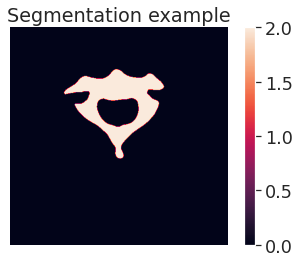

In [6]:
plt.figure()
plt.imshow(example[119])
plt.title('Segmentation example')
plt.colorbar()
plt.axis('off')
plt.show()

**Extract vertebrae from segmentations**

In [7]:
# Initialise targets
targets = ['C1','C2','C3','C4','C5','C6','C7']
meta_seg[targets]=0

In [8]:
'''
k=0
# Loop over 87 patients with segmentations
for path, UID in zip(seg_df['path'], seg_df['StudyInstanceUID']):
    # Get segmentations for patient
    seg_nib = nib.load(path)
    seg = seg_nib.get_fdata()
    seg = seg[:, ::-1, ::-1].transpose(2, 1, 0) # Align orientation with train images
    num_slices, _, _ = seg.shape
    
    # Loop over slices
    for i in range(num_slices):
        mask = seg[i]
        unique_vals = np.unique(mask)
        
        # Loop over unique values (except 0)
        for j in unique_vals[1:]:
            
            # Ignore thoratic spine etc
            if j <= 7:   
                meta_seg.loc[(meta_seg['StudyInstanceUID']==UID)&(meta_seg['Slice']==i),f'C{int(j)}'] = 1
                
    # Iteration tracker
    if (k%10)==0:
        print(f'Iteration:{k}')
    k+=1

# Save extracted targets
meta_seg.to_csv("meta_segmentation.csv", index=False)
'''

'\nk=0\n# Loop over 87 patients with segmentations\nfor path, UID in zip(seg_df[\'path\'], seg_df[\'StudyInstanceUID\']):\n    # Get segmentations for patient\n    seg_nib = nib.load(path)\n    seg = seg_nib.get_fdata()\n    seg = seg[:, ::-1, ::-1].transpose(2, 1, 0) # Align orientation with train images\n    num_slices, _, _ = seg.shape\n    \n    # Loop over slices\n    for i in range(num_slices):\n        mask = seg[i]\n        unique_vals = np.unique(mask)\n        \n        # Loop over unique values (except 0)\n        for j in unique_vals[1:]:\n            \n            # Ignore thoratic spine etc\n            if j <= 7:   \n                meta_seg.loc[(meta_seg[\'StudyInstanceUID\']==UID)&(meta_seg[\'Slice\']==i),f\'C{int(j)}\'] = 1\n                \n    # Iteration tracker\n    if (k%10)==0:\n        print(f\'Iteration:{k}\')\n    k+=1\n\n# Save extracted targets\nmeta_seg.to_csv("meta_segmentation.csv", index=False)\n'

In [9]:
meta_seg = pd.read_csv('../input/rsna-2022-spine-fracture-detection-metadata/meta_segmentation.csv')
meta_seg.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976,0,0,0,0,0,0,0


**Examples**

In [10]:
# Example
meta_seg[['StudyInstanceUID','Slice']+targets].iloc[199:204,:]

,StudyInstanceUID,Slice,C1,C2,C3,C4,C5,C6,C7
199,1.2.826.0.1.3680043.10633,200,0,1,1,0,0,0,0
200,1.2.826.0.1.3680043.10633,201,0,1,1,0,0,0,0
201,1.2.826.0.1.3680043.10633,202,0,0,1,1,0,0,0
202,1.2.826.0.1.3680043.10633,203,0,0,1,1,0,0,0
203,1.2.826.0.1.3680043.10633,204,0,0,1,1,0,0,0


In [11]:
# Print example of extracted vertebrae
print('UID:', meta_seg['StudyInstanceUID'].unique()[0])
pd.set_option('display.max_rows', 500)
meta_seg[meta_seg['StudyInstanceUID']==meta_seg['StudyInstanceUID'].unique()[0]].loc[110:340,targets]

UID: 1.2.826.0.1.3680043.10633


,C1,C2,C3,C4,C5,C6,C7
110,0,0,0,0,0,0,0
111,1,0,0,0,0,0,0
112,1,0,0,0,0,0,0
113,1,0,0,0,0,0,0
114,1,0,0,0,0,0,0
115,1,0,0,0,0,0,0
116,1,0,0,0,0,0,0
117,1,0,0,0,0,0,0
118,1,0,0,0,0,0,0
119,1,0,0,0,0,0,0


Notice how the targets are **monotonic** (C1->C2->C3...) and sometimes **overlap** (e.g. C1 and C2 can appear in the same image). 

Thoughts:
* We can use this df to train a model to **identify targets** for the **rest of the train images**. 
* We can **first** try building a model using the **metadata only** (this will be faster) as a baseline.
* Imposing **monotonicity** will be tricky (maybe we can try to predict the slices where the vertebrae **appear** and **disappear** as opposed trying to predict which vertebrae is in every image).
* Then we can then try to use the **image data** as well for the highest accuracy (this will be more time comsuming). 

<hr>

**Build baseline supervised model**

In [12]:
# Calculate slice ratio (to generalise better)
slice_max_seg = meta_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
meta_seg['SliceRatio'] = 0
meta_seg['SliceRatio'] = meta_seg['Slice']/meta_seg['StudyInstanceUID'].map(slice_max_seg)

In [13]:
features = ['SliceRatio','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z']

# Features and targets
X = meta_seg[['StudyInstanceUID']+features]
y = meta_seg[targets]

In [14]:
# Train-valid split, grouped by patient (80/20 split)
gkf = GroupKFold(n_splits=5)
(train_idx, valid_idx) = next(gkf.split(X, y, groups = X['StudyInstanceUID']))

# Train set
X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx,:]

# Validation set
X_valid, y_valid = X.iloc[valid_idx,:], y.iloc[valid_idx,:]

# Drop patient id
X_train = X_train.drop('StudyInstanceUID', axis=1)
X_valid = X_valid.drop('StudyInstanceUID', axis=1)

In [15]:
# Train classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
# Evaluate model
y_preds = clf.predict(X_valid)

total_acc = 0 
for i in range(7):
    acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    total_acc+=acc/7
    print(f'Accuracy of C{i+1}: {acc} %')

print('')
print(f'Overall accuracy: {total_acc} %')

Accuracy of C1: 0.8962887646161668 %
Accuracy of C2: 0.8901881037112354 %
Accuracy of C3: 0.9008642602948653 %
Accuracy of C4: 0.8969666158278258 %
Accuracy of C5: 0.8854431452296221 %
Accuracy of C6: 0.8678190137264871 %
Accuracy of C7: 0.8547703779020505 %

Overall accuracy: 0.8846200401868932 %


In [17]:
# Feature importances
pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
0,SliceRatio,0.577253
4,ImagePositionPatient_z,0.211313
3,ImagePositionPatient_y,0.090770
2,ImagePositionPatient_x,0.088306
1,SliceThickness,0.032358


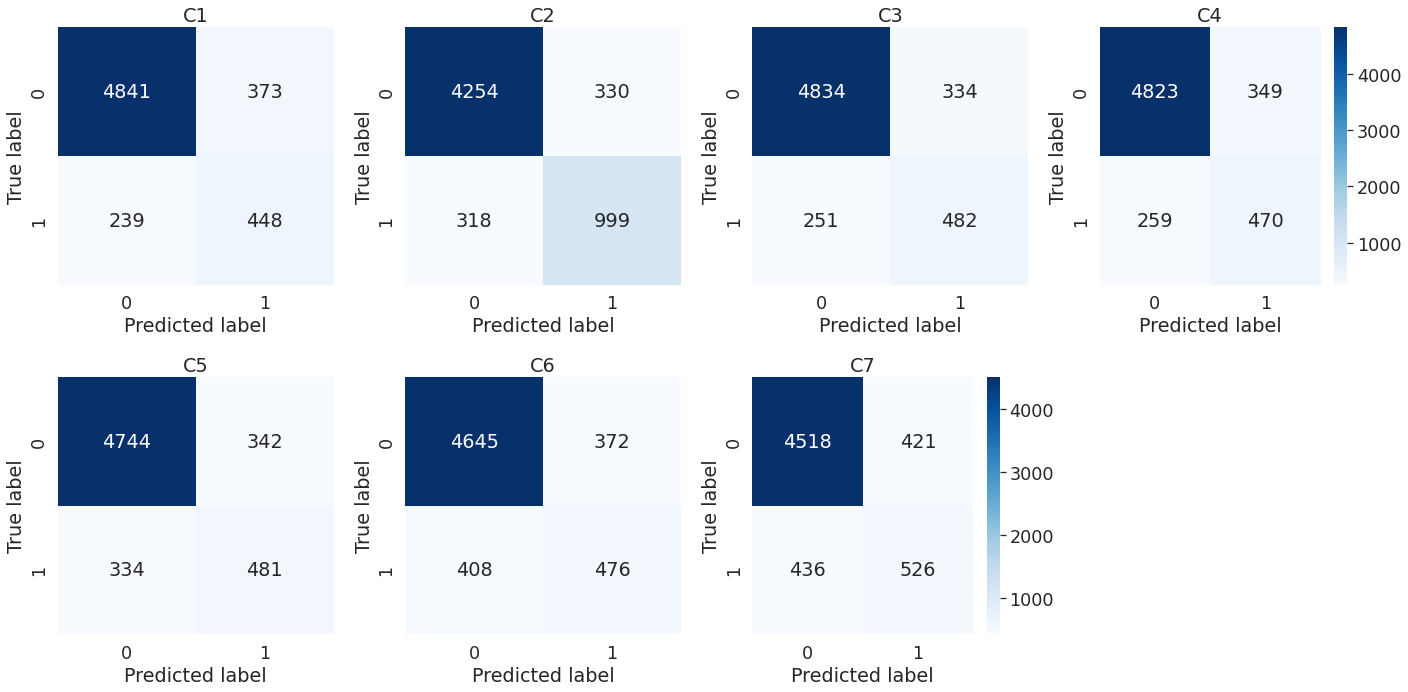

In [18]:
preds = clf.predict(X_valid)

# Confusion matrices
fig = plt.figure(figsize=(20,10))
for i in range(7):
    cm = confusion_matrix(preds[:,i], y_valid.values[:,i])
    plt.subplot(2,4,i+1)
    CBAR=False
    if (i==3) or (i==6):
        CBAR=True
    sns.heatmap(cm, annot=True, fmt='d', cbar=CBAR, cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'C{i+1}')
fig.tight_layout()

**Example of predictions**

In [19]:
np.set_printoptions(threshold=np.inf)
clf.predict(X.drop('StudyInstanceUID',axis=1))[110:250,:]

array([[1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1,

It seems to be preserving monotonicity quite well.

**Predict vertebrae numbers on entire train set**

In [20]:
# Read in metadata for entire train set
meta_train = pd.read_csv('../input/rsna-2022-spine-fracture-detection-metadata/meta_train_clean.csv')

# Calculate slice ratio (to generalise better)
slice_max_train = meta_train.groupby('StudyInstanceUID')['Slice'].max().to_dict()
meta_train['SliceRatio'] = 0
meta_train['SliceRatio'] = meta_train['Slice']/meta_train['StudyInstanceUID'].map(slice_max_train)

# Initialise targets
meta_train[targets]=0

# Predict targets for entire train set
meta_train[targets] = clf.predict(meta_train[features])

# We know images with segmentations have 100% accurate targets so put these back in
meta_train.loc[meta_train['StudyInstanceUID'].isin(meta_seg['StudyInstanceUID']),targets] = meta_seg[targets].values

# Save to csv
meta_train.to_csv('meta_train_with_vertebrae.csv', index=False)

# Preview
meta_train.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,SliceRatio,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.003731,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.007463,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.011194,0,0,0,0,0,0,0


**Plot distributions**

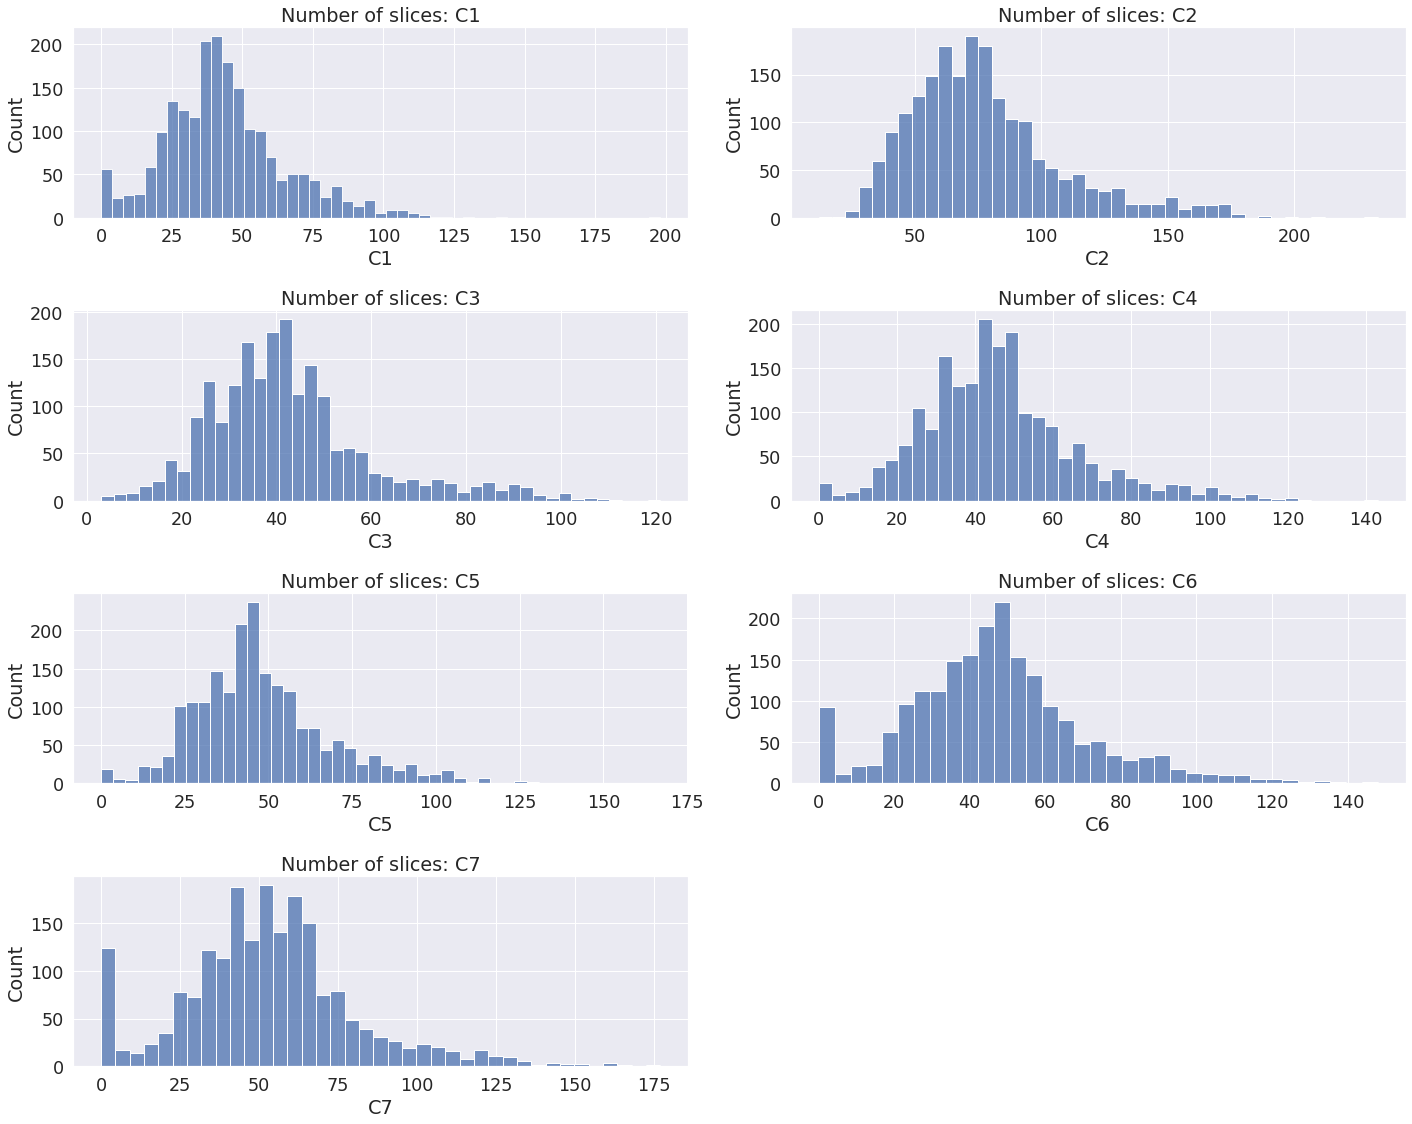

In [21]:
fig = plt.figure(figsize=(20,16))
for i, Cx in enumerate(targets):
    plt.subplot(4,2,i+1)
    sns.histplot(meta_train.groupby('StudyInstanceUID')[Cx].sum())
    plt.title(f'Number of slices: {Cx}')
fig.tight_layout()